# Dependency parser
## Atanas Atanasov

**Table of contents**<a id='toc0_'></a>    
- [Abstract](#toc2_2_)    
- [Prerequisites](#toc2_3_)    
- [Introduction](#toc2_4_)    
  - [Linguistic background](#toc2_4_1_)    
  - [Universal Dependencies](#toc2_4_2_)    
  - [Dependency parsing background](#toc2_4_3_)    
  - [Deep Biaffine Attention](#toc2_4_4_)    
- [Data preparation](#toc2_5_)    
  - [Load data](#toc2_5_1_)    
  - [Build vocabularies](#toc2_5_2_)    
  - [Configuration](#toc2_5_3_)    
  - [Data Vectorization](#toc2_5_4_)    
- [The Model](#toc2_6_)    
  - [Batching and Shuffling the Datasets](#toc2_6_1_)    
  - [Model Architecture](#toc2_6_2_)    
  - [Model Implementation](#toc2_6_3_)    
  - [Setup and Training](#toc2_6_4_)    
- [Experiments and Results](#toc2_7_)    
- [Predictions](#toc2_8_)    
    - [Tokenization](#toc2_8_1_1_)    
    - [Text to CoNLL-U](#toc2_8_1_2_)    
    - [Visualization](#toc2_8_1_3_)    
    - [Demo](#toc2_8_1_4_)    
- [Future Work](#toc2_9_)    
- [Conclusion](#toc2_10_)    
- [References](#toc2_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc2_2_'></a>[Abstract](#toc0_)

The paper explores the implementation of a Biaffine Attention Model, a sophisticated neural network architecture used for dependency parsing tasks. This model, proposed by Dozat and Manning, is applied in the context of Bulgarian language processing. Training and evaluation of the model are conducted using the Bulgarian Universal Dependencies dataset. The paper provides an in-depth explanation of the model's architecture and the data preparation process. The results of the experiments are then presented and discussed. The paper concludes with a discussion on the model's performance and suggestions for potential future work.

## <a id='toc2_3_'></a>[Prerequisites](#toc0_)

This notebook, written in Python 3.11, has been tested on WSL2 Ubuntu 22.04.3 LTS. The required packages are listed in the [requirements.txt](./requirements.txt) file. Also [environment.yml](./environment.yml) is provided for convenience[<sup>*</sup>](#note-1).

---
<small><a id="note-1"></a><sup>*</sup> Note that the virtual environment includes packages not directly used in this notebook, such as PyTorch and Transformers, which are for side experiments. If disk space is limited, consider manually installing only the necessary packages.<small>

Below are the packages imported for use in this notebook:

In [1]:
%matplotlib inline
%load_ext tensorboard

In [2]:
import datetime
import json

import classla
import mlflow
import tensorflow as tf
import tensorflow_datasets as tfds
from mlflow.tensorflow import MLflowCallback
from spacy import displacy
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import Callback, TensorBoard
from tensorflow.keras.layers import (
    LSTM,
    Bidirectional,
    Dense,
    Dropout,
    Embedding,
    Input,
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

from transformers import BertTokenizerFast, BertModel

2024-04-17 17:48:53.015248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 17:48:53.015310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 17:48:53.063334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 17:48:53.178162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 17:48:54.308646: W tensorflow/compiler/tf2

The next cell checks if a GPU is available for TensorFlow to use and enables memory growth for the GPU. This can be useful to avoid using all of the GPU memory.

In [3]:
if tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices()[1], True)
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


2024-04-17 17:48:59.539527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 17:48:59.544546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 17:48:59.544578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## <a id='toc2_4_'></a>[Introduction](#toc0_)


This paper aims to implement a neural network-based dependency parser using TensorFlow and Keras. The parser will be trained and evaluated on the Bulgarian Universal Dependencies dataset.

### <a id='toc2_4_1_'></a>[Linguistic background](#toc0_)
From a linguistic perspective, Generative Grammar (GG) and Dependency Grammar (DG) have emerged as the two primary approaches to syntax study over the past few decades[<sup>*</sup>](#note-2). GG is a grammar model that operates on the premise that a sentence's syntactic structure is generated by a set of rules. These rules are applied to a set of terminal nodes, which are the words (or potentially empty functional categories) of the sentence. The rules are recursively applied until the sentence is parsed into its smallest constituents. The result of constituency parsing is a tree, known as a constituency parse tree, which represents the sentence's syntactic structure.

On the other hand, DG is a grammar model that posits that a sentence's syntactic structure is represented by a set of dependencies between the sentence's words. These dependencies are directed links between the words of the sentence and are represented by a tree, known as a dependency parse tree. The nodes of the dependency parse tree are the words of the sentence, and the edges (arcs) represent the dependencies between the words. The dependency parse tree has a root node, typically the main verb (predicate) of the sentence. This root node has no incoming edges but can have multiple outgoing edges. The dependency parse tree is a directed acyclic graph (DAG), meaning there are no cycles in the graph and only one path exists between any two nodes in the tree.

In recent decades, Generative Grammar (GG) has been the preferred approach for representing syntactic structures in most linguistic studies. However, due to advancements in Natural Language Processing (NLP), particularly the Universal Dependencies (UD) project and deep learning models based on it, DG is gaining popularity. The primary advantage of DG lies in its simplicity and intuitiveness, despite GG's greater expressiveness.  

---
<small><a id="note-2"></a><sup>*</sup> In fact, the concept behind the dependency approach dates back several thousand years. However, it wasn't until the 20th century that it was formalized and evolved into a comprehensive theory.<small>

### <a id='toc2_4_2_'></a>[Universal Dependencies](#toc0_)

<a href="https://universaldependencies.org">Universal Dependencies</a> (UD) is a framework for consistent annotation of grammar (parts of speech, morphological features, and syntactic dependencies) across different languages. It is an open community effort with over 200 contributors producing more than 100 treebanks in over 70 languages.

The goal of UD is to enable multilingual parser development, cross-lingual learning, and parsing research from a language typology perspective. It is a highly influential resource in the field of Natural Language Processing (NLP).

The UD project provides a set of universal guidelines that aim to be applicable to all languages, along with language-specific extensions. The guidelines cover annotation at the word level (morphology) and the sentence level (syntax).

The UD treebanks, which are collections of annotated sentences, are a valuable resource for training and evaluating NLP models, such as part-of-speech taggers and dependency parsers.

### <a id='toc2_4_3_'></a>[Dependency parsing background](#toc0_)
There are two main approaches to dependency parsing: transition-based and graph-based. The transition-based (shift-reduce) approach is a greedy algorithm that builds a dependency tree by applying a sequence of actions to a partially built tree. They maintain a stack and a buffer of words to be processed. The parsing process starts with all words in the buffer and an empty stack. The parser can perform three types of actions: 'SHIFT' (moves a word from the buffer to the stack); 'REDUCE' (removes a word from the stack); 'ARC' (creates a dependency relation between two words, one from the stack and one from the buffer). The parser makes these actions based on a set of features extracted from the current state of the stack and buffer, and the previously built dependency relations. The process continues until the buffer is empty and all words have been incorporated into the dependency tree. This parsers do not use deep learning algorithms for direct prediction of dependencies, instead they use it to predict the next action to be taken.
  
Graph-based parsers, on the other hand, work by considering all possible dependency trees for a sentence and choosing the one with the highest score. The score of a tree is typically computed as the sum of the scores of its individual dependencies. The scoring function is learned from a treebank during training. The learning process involves finding weights for the features of the dependencies such that the correct trees in the training data get higher scores than incorrect trees.  
  
Transition-based parsers are generally more efficient, as they parse a sentence in linear time. This makes them suitable for real-time applications or large-scale data processing. However, these parsers suffer from error propagation. The decisions are made greedily, and once a parsing action is taken, it cannot be undone. This means that an error early in the parsing process can affect the rest of the parse. Graph-based parsers often achieve higher accuracy than transition-based parsers. They globally optimize the parse tree of a sentence, considering all possible trees before making a decision. However, this global optimization comes at a cost. Graph-based parsers have a higher time complexity (usually cubic in the length of the sentence), making them slower than transition-based parsers.

### <a id='toc2_4_4_'></a>[Deep Biaffine Attention](#toc0_)
This notebook implements a graph-based dependency parser, based on the algorithm proposed by <a href="https://openreview.net/forum?id=Hk95PK9le">Dozat and Manning (2017)</a>[<sup>1</sup>](#ref-1). Their architecture leverages a bi-LSTM (Bidirectional Long Short-Term Memory) that reads the input sentence from both directions, capturing a rich set of syntactic and semantic features. Additionally, the authors introduce a biaffine attention mechanism, a bilinear function with an added affine transformation. Instead of using shallow bilinear attention, which operates directly on recurrent state representations, deep biaffine attention employs a multi-layer perceptron (MLP) to project these representations into a higher-dimensional space before applying the bilinear attention function. This allows the model to capture more complex relationships between words and their potential dependencies.  
  
The parser proposed here is trained and evaluated on the Bulgarian UD treebank.

## <a id='toc2_5_'></a>[Data preparation](#toc0_)


The UD treebanks come in various formats, including CoNLL-U (a format used for linguistic treebanks in the Conference on Natural Language Learning), TensorFlow Datasets (TFDS), and HuggingFace Datasets. Given that this project uses TensorFlow, TFDS is the most convenient format. The treebanks are always split into training, development, and test sets.

### <a id='toc2_5_1_'></a>[Load data](#toc0_)


The three subsets of the Bulgarian UD treebank will be loaded from TFDS, along with the dataset information necessary for predictions.

In [4]:
(bg_btb_train, bg_btb_dev, bg_btb_test), info = tfds.load(
    "universal_dependencies/bg_btb", split=["train", "dev", "test"], with_info=True
)

2024-04-17 17:49:06.842665: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 17:49:06.842742: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 17:49:06.842762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 17:49:07.133384: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 17:49:07.133429: I external/local_xla/xla/stream_executor

In [5]:
len(bg_btb_train), len(bg_btb_dev), len(bg_btb_test)

(8907, 1115, 1116)

The dataset includes 8907 training sentences, 1115 development sentences, and 1116 test sentences. This distribution corresponds to approximately 80% of the data for training, 10% for validation, and 10% for testing. This is a typical distribution for UD treebanks and is suitable for developing a neural network parser, so no additional splitting is required.

Before processing the data, let's examine a few sentences to understand the dataset's structure. Here is the specification of the dataset's elements:

In [6]:
bg_btb_train.element_spec

{'deprel': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'deps': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'feats': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'head': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'idx': TensorSpec(shape=(), dtype=tf.string, name=None),
 'lemmas': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'misc': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'text': TensorSpec(shape=(), dtype=tf.string, name=None),
 'tokens': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'upos': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'xpos': TensorSpec(shape=(None,), dtype=tf.string, name=None)}

All columns have a dtype of tf.string, except for 'upos', which is tf.int64. These columns need careful examination and conversion to the appropriate format before model training. Displaying the first few rows in a table will help understand the data structure.

In [7]:
tfds.as_dataframe(bg_btb_train.take(2), info)

2024-04-17 17:49:11.315410: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,deprel,deps,feats,head,idx,lemmas,misc,text,tokens,upos,xpos
0,nsubjrootcaseamodoblcaseamod...,"[('nsubj', 2)][('root', 0)][('case', 5)][('amod', 5)][('obl:със', 2)][('case', 8)][('amod', 8)]...","{'Definite': 'Def', 'Gender': 'Neut', 'Number': 'Sing'}{'Aspect': 'Imp', 'Mood': 'Ind', 'Number': 'Sing', 'Person': '3', 'Tense': 'Pres', 'VerbForm': 'Fin', 'Voice': 'Act'}None{'Definite': 'Def', 'Degree': 'Pos', 'Gender': 'Fem', 'Number': 'Sing'}{'Definite': 'Ind', 'Gender': 'Fem', 'Number': 'Sing'}None{'Definite': 'Def', 'Degree': 'Pos', 'Gender': 'Masc', 'Number': 'Sing'}...",2055288...,random2-s483,заседаниепродължавамсъссъщточкаотдневен...,NoneNoneNoneNoneNoneNoneNone...,Заседанието продължава със същата точка от дневния ред.,Заседаниетопродължавасъссъщататочкаотдневния...,7 (NOUN)15 (VERB)1 (ADP)0 (ADJ)7 (NOUN)1 (ADP)0 (ADJ)...,NcnsdVpitf-r3sRAfsdNcfsiRAmsh...
1,discourseadvmodadvmodiobjexplrootaux...,"[('discourse', 6)][('advmod', 6)][('advmod', 6)][('iobj', 6)][('expl', 6)][('root', 0)][('aux', 8)]...","None{'Definite': 'Ind', 'Degree': 'Pos', 'Number': 'Plur', 'NumType': 'Card'}{'Polarity': 'Neg'}{'Case': 'Dat', 'Number': 'Sing', 'Person': '1', 'PronType': 'Prs'}{'Case': 'Acc', 'PronType': 'Prs', 'Reflex': 'Yes'}{'Aspect': 'Perf', 'Mood': 'Ind', 'Number': 'Sing', 'Person': '3', 'Tense': 'Pres', 'VerbForm': 'Fin', 'Voice': 'Act'}None...",6666608...,random2-s108,даноповеченеазсеналожа-(се)да...,NoneNoneNoneNoneNoneNoneNone...,"Дано повече не ми се наложи да защитавам правото си на глас, като си бръсна главата или сека телевизори с брадва.",Даноповеченемисеналожида...,9 (PART)2 (ADV)9 (PART)10 (PRON)10 (PRON)15 (VERB)3 (AUX)...,TmMd--iTnPpetds1PpxtaVpptf-r3sTx...


In the dependency parser, only certain columns are used. The `tokens` column, with the tokenized sentence, and the `upos` column, with Universal Part-of-Speech tags, train the parser. The `deprel` column, with dependency relations, and the `head` column, indicating word head indices, serve as the parser's targets.

The other columns are not used in this project, but they contain valuable information for other NLP tasks, such as lemmatization, morphological analysis, and named entity recognition. Here is a brief description of each of them: 
- `deps` column is used for additional dependency relations in enhanced dependency graph representations. It's basically a combination of deprel, head, and (eventually) tokens columns.
- `feats` column contains morphological features of the words.
- `idx` column is the index of the sentence.
- `lemmas` contains the lemmatized forms of the words.
- `misc` column is used for any miscellaneous information that doesn't fit into the other columns.
- `text` column contains the original (row) sentence.
- `xpos` column contains the language-specific part-of-speech tags. These tags can provide more detailed grammatical information than the universal tags, but they are not consistent across languages.

### <a id='toc2_5_2_'></a>[Build vocabularies](#toc0_)


Now that the data is loaded, the next step is to build the vocabularies. This sets of unique words, Universal Part-of-Speech tags, and dependency relations from the training set will be converted into numerical representations for the model to process. The vocabulary helps convert words and tags into these representations, while the dependency relations are used to construct the target vectors for the parser.

The following function is designed to extract the unique values from a dataset column and return them as a list:

In [8]:
def get_unique_values(dataset, key):
    unique = tf.unique(tf.concat([t for t in dataset.map(lambda x: x[key])], axis=0)).y
    return unique.numpy().tolist()

Next, the `get_hash_tables` function is created to build vocabularies for words, Universal Part-of-Speech tags, and dependency relations. It uses `get_unique` to extract unique values from the dataset and creates a hash table for efficient mapping of these values to their numerical representations. While a Python dictionary is often used for this purpose, TensorFlow's hash table is more efficient for handling TensorFlow tensors.  

The function begins by adding special tokens `<PAD>`, `<ROOT>`, and `<UNK>` to the vocabularies. `<PAD>` is used to equalize input sequence lengths, `<ROOT>` represents the root of the dependency parse tree (the dummy token that governs the main verb of the sentence), and `<UNK>` represents unknown words, tags, or relations.  

Two hash tables are created: `id2label_table` and `label2id_table`. The `id2label_table` maps IDs to labels, and the `label2id_table` maps labels to IDs. These tables are used to convert between numerical IDs and their corresponding labels during training and prediction.

In [9]:
def get_hash_tables(dataset, key):
    unique = get_unique_values(dataset, key)

    t_dtype = dataset.element_spec[key].dtype
    pad, root, unk = ("<PAD>", "<ROOT>", "<UNK>") if t_dtype == tf.string else (0, 1, 2)

    ds_dict = {0: pad, 1: root, 2: unk}
    ds_dict.update({i + 3: l for i, l in enumerate(unique)})
    id2label_table = tf.lookup.StaticHashTable(
        initializer=tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(list(ds_dict.keys())),
            values=tf.constant(list(ds_dict.values())),
        ),
        default_value=tf.constant(ds_dict[2]),
        name="class_weight",
    )

    reverse_ds_dict = {l: i for i, l in ds_dict.items()}
    label2id_table = tf.lookup.StaticHashTable(
        initializer=tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(list(reverse_ds_dict.keys())),
            values=tf.constant(list(reverse_ds_dict.values())),
        ),
        default_value=tf.constant(2),
        name="reverse_class_weight",
    )

    return id2label_table, label2id_table

The function is now used to build vocabularies for words, Universal Part-of-Speech tags, and dependency relations. Since the `head` column only contains indices (the head of a word is the word that governs its syntactic function), it doesn't require a vocabulary. The `head` indices are later converted to numeric values, as they are in tensors of type tf.string, but no mapping is needed for them.

In [10]:
id2token, token2id = get_hash_tables(bg_btb_train, "tokens")

In [11]:
id2deprel, deprel2id = get_hash_tables(bg_btb_train, "deprel")

In [12]:
id2upos, upos2id = get_hash_tables(bg_btb_train, "upos")

In [13]:
id2lemma, lemma2id = get_hash_tables(bg_btb_train, "lemmas")

In [14]:
id2xpos, xpos2id = get_hash_tables(bg_btb_train, "xpos")

With the vocabularies built, they can now map values to their numerical representations:

In [15]:
token2id[tf.constant('съм')]

<tf.Tensor: shape=(), dtype=int32, numpy=334>

In [16]:
token2id.lookup(tf.constant('съм')).numpy()

334

In [17]:
lemma2id.lookup(tf.constant('съм')).numpy()

47

or vice versa:

In [18]:
id2deprel[tf.constant([0, 1, 2, 3, 4, 5])]

<tf.Tensor: shape=(6,), dtype=string, numpy=
array([b'<PAD>', b'<ROOT>', b'<UNK>', b'nsubj', b'root', b'case'],
      dtype=object)>

In [19]:
id2deprel.lookup(tf.constant([0, 1, 2, 3, 4, 5]))

<tf.Tensor: shape=(6,), dtype=string, numpy=
array([b'<PAD>', b'<ROOT>', b'<UNK>', b'nsubj', b'root', b'case'],
      dtype=object)>

In [20]:
id2lemma.lookup(tf.constant([0, 1, 2, 3, 4, 5])).numpy()

array([b'<PAD>', b'<ROOT>', b'<UNK>',
       b'\xd0\xb7\xd0\xb0\xd1\x81\xd0\xb5\xd0\xb4\xd0\xb0\xd0\xbd\xd0\xb8\xd0\xb5',
       b'\xd0\xbf\xd1\x80\xd0\xbe\xd0\xb4\xd1\x8a\xd0\xbb\xd0\xb6\xd0\xb0\xd0\xb2\xd0\xb0\xd0\xbc',
       b'\xd1\x81\xd1\x8a\xd1\x81'], dtype=object)

Finally, the `upos` values, given as tf.int64, need to be mapped to their actual labels. These labels are necessary for predicting and presenting sentence syntax analysis and can be obtained from the dataset's `info`.

In [21]:
upos_keys = tf.constant(list(range(len(info.features["upos"].names))), dtype=tf.int32)
# <tf.Tensor: shape=(18,), dtype=int32, numpy=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17], dtype=int32)>
upos_vals = tf.constant(info.features["upos"].names)
# <tf.Tensor: shape=(18,), dtype=string, numpy=array([b'ADJ', b'ADP', b'ADV', b'AUX', b'CCONJ', b'DET', ...], dtype=object)>

upos2str = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(upos_keys, upos_vals), default_value="_"
)
str2upos = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(upos_vals, upos_keys), default_value=-1
)

### <a id='toc2_5_3_'></a>[Configuration](#toc0_)

The `Config` class plays a crucial role in this project. It establishes the configuration parameters for the model, including hyperparameters sourced from a [JSON file](./config.json), and the sizes of hash tables that represent the total number of unique tokens, UPOS tags, and dependency relations in the dataset. While the majority of its parameters pertain to the model itself, it must be loaded at this stage because the vectorization of the data, performed in the subsequent chapter, utilizes it.

All this information is stored in the `config` object, which is referenced throughout the notebook for accessing the configuration parameters.

In [25]:
class Config:
    def __init__(self, token2id, upos2id, deprel2id, lemma2id, xpos2id, json_file_path):
        with open(json_file_path, 'r') as file:
            config_data = json.load(file)

        self.tokens_size = token2id.size().numpy()
        self.upos_size = upos2id.size().numpy()
        self.deprel_size = deprel2id.size().numpy()
        self.lemmas_size = lemma2id.size().numpy()
        self.xpos_size = xpos2id.size().numpy()
        
        self.__dict__.update(config_data)

    def get_config(self):
        config = {
            'tokens_size': self.tokens_size,
            'upos_size': self.upos_size,
            'deprel_size': self.deprel_size,
            'lemmas_size': self.lemmas_size,
            'xpos_size': self.xpos_size
        }
        config.update(self.__dict__)
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [26]:
config = Config(token2id, upos2id, deprel2id, lemma2id, xpos2id, 'config.json')

In [27]:
vars(config)

{'tokens_size': 25050,
 'upos_size': 16,
 'deprel_size': 38,
 'lemmas_size': 13296,
 'xpos_size': 539,
 'embedding_size': 100,
 'embedding_dropout': 0.5,
 'lstm_size': 400,
 'lstm_dropout': 0.5,
 'arc_mlt_size': 500,
 'arc_mlt_dropout': 0.5,
 'label_mlt_size': 100,
 'label_mlt_dropout': 0.5,
 'lstm_depth': 3,
 'mlt_depth': 1,
 'learning_rate': 0.002,
 'adam_beta_1': 0.9,
 'adam_beta_2': 0.9,
 'annealing_factor': 0.075,
 'annealing_steps': 2000,
 'batch_size': 128,
 'padding_size': 128,
 'num_epochs': 80}

### <a id='toc2_5_4_'></a>[Data Vectorization](#toc0_)

This chapter describes the process of vectorization, which converts the dataset into a format that the neural network can process.

The `vectorize_dataset` function is central to this process. It takes a dataset as input and returns a new dataset where each element is a tuple of **inputs** and **outputs**.

The `tokens`, `upos`, and `deprel` values are encoded as integers using the corresponding hash tables. The `heads` values are simply cast to numbers. All sequences are padded to ensure uniform length. The `sentences_len` variable represents the length of each sentence, including an extra token for the root of the dependency parse tree.

The **inputs** in the returned dataset are the vectorized `tokens` and `upos` values, along with `sentences_len`. The **outputs** are the vectorized `heads` and `deprel` values.

The `encode_values` function encodes the `tokens`, `upos`, and `deprel` values. If the values are of type `tf.int64`, they are cast to `tf.int32` before encoding, because of `tf.lookup.StaticHashTable` requirements. Each sequence is prepended with a dummy value to represent the root of the dependency parse tree.

The `apply_padding` function ensures all sequences have the same length, padding or truncating sequences to a maximum length of 128 tokens.

Finally, the `tf.data.Dataset.from_tensor_slices` function generates a new dataset from the vectorized inputs and outputs. This dataset, ready for batching, can be used for model training or prediction.

In [28]:
def encode_values(dataset, key, hash_table, dummy_value):
    if dataset.element_spec[key].dtype == tf.int64:
        return dataset.map(
            lambda x: tf.concat([tf.constant([dummy_value]), hash_table[tf.cast(x[key], tf.int32)]], axis=0))
    return dataset.map(
        lambda x: tf.concat([tf.constant([dummy_value]), hash_table[x[key]]], axis=0))

def apply_padding(tensor, max_length=config.padding_size):
    return tf.keras.utils.pad_sequences(
        tensor, maxlen=max_length, padding="post", truncating="post"
    )

def vectorize_dataset(dataset):
    tokens = apply_padding(encode_values(dataset, "tokens", token2id, 1))
    upos = apply_padding(encode_values(dataset, "upos", upos2id, 1))
    lemmas = apply_padding(encode_values(dataset, "lemmas", lemma2id, 1))
    xpos = apply_padding(encode_values(dataset, "xpos", xpos2id, 1))
    sentences_len = tf.constant([x["tokens"].shape[0] + 1 for x in dataset])
    deprel = apply_padding(encode_values(dataset, "deprel", deprel2id, 1))
    heads = apply_padding(dataset.map(lambda x: tf.concat(
                [tf.constant([0]), tf.strings.to_number(x["head"], tf.int32)], axis=0)))

    inputs = (tokens, upos, lemmas, xpos, sentences_len)
    outputs = (heads, deprel)

    return tf.data.Dataset.from_tensor_slices((inputs, outputs))

In [29]:
train_dataset = vectorize_dataset(bg_btb_train)

In [30]:
dev_dataset = vectorize_dataset(bg_btb_dev)

In [31]:
test_dataset = vectorize_dataset(bg_btb_test)

In [32]:
first_element = next(test_dataset.take(1).as_numpy_iterator())
print(first_element)

((array([    1,     2,  2425,  2445,   385,  1403,    22,  1090,    58,
       17366, 10595,   163,    11,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     

## <a id='toc2_6_'></a>[The Model](#toc0_)


This chapter introduces the project's primary neural network model, designed for dependency parsing, a key aspect of natural language understanding.

Built with TensorFlow and the Keras API, the model incorporates several components. These include embedding layers for words and POS tags, BiLSTM layers for sentence encoding, and MLP layers for predicting arcs and relations between words. The model also features Biaffine layers, a unique element that enables prediction of arcs and relations between words.

The model is equipped with a custom loss function and an Adam optimizer for training. It also includes metrics for tracking the loss and accuracy during training and evaluation.

This chapter will explore each model component in detail, explaining their functions and contributions to dependency parsing.

### <a id='toc2_6_1_'></a>[Batching and Shuffling the Datasets](#toc0_)

This code segment batches and shuffles the datasets. The `batch` method groups the dataset into batches of a specified size, as defined in `config`. This is essential for efficient model training, as it allows multiple examples to be processed simultaneously.

The `shuffle` method randomizes the order of the examples in the dataset, preventing the model from learning any potential order in the data and improving its ability to generalize.

Lastly, the `prefetch` method enables the dataset to fetch batches asynchronously while the model is training, reducing waiting time for data fetching and improving the speed of the training process.

In [33]:
train_data = train_dataset.shuffle(20000, reshuffle_each_iteration=True)
train_data = train_dataset.batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
dev_data = dev_dataset.batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_dataset.batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

The data is now fully prepared for model training.

### <a id='toc2_6_2_'></a>[Model Architecture](#toc0_)

As it was already mentioned, the model is based on the architecture proposed in "*Deep Biaffine Attention for Neural Dependency Parsing*" by Dozat and Manning (2017), which builds off the work from Kiperwasser & Goldberg (2016)[<sup>2</sup>](#ref-2) with a few modifications. The graph-based algorithm is illustrated in the following figure:  

![Biaffine Attention](./biaffine-attention.png)

Dozat and Manning use a larger but more thoroughly regularized parser, with biaffine classifiers to predict arcs and labels. They use biaffine attention instead of bilinear or traditional MLP-based attention; a biaffine dependency label classifier; and apply dimension-reducing MLPs to each recurrent output vector $\text{r}_i$ before applying the biaffine transformation. The biaffine mechanism is similar to traditional affine classifiers, where the vector of scores $\text{s}_i$ for all classes equals the weight matrix $\text{W}$ multiplied by single LSTM output state $\text{r}_i$ (or other vector input) plus the bias term $\text{b}$:

(1)<a id="formula-1"></a>
$$
\text{s}_i = W \text{r}_i + \text{b} 
$$
$$
\text{(Fixed-class affine classifier)}
$$
In the biaffine mechanism, the weight matrix $\text{W}$ is replaced by a $(d \times d)$ linear transformation of the stacked LSTM output $RU^{(1)}$ and a $(d \times d)$ transformation $R\text{u}^{(2)}$ replaces the bias term $\text{b}$:

(2)<a id="formula-2"></a>
$$ 
\text{s}_{i}^{(arc)} = \left(RU^{(1)}\right) r_i + \left(R\text{u}^{(2)}\right)  
$$
$$
\text{(Variable-class biaffine classifier)}
$$
Along with being simpler than the MLP-based approach, this has the conceptual advantage of directly modeling both the prior probability of a word $j$ receiving any dependents in the term $\text{r}_j^\intercal \text{u}^{(2)}$ and the likelihood of $j$ receiving a specific dependent $i$ in the term $\text{r}_j^\intercal U^{(1)}\text{r}_i$.
The authors also use a biaffine classifier to predict dependency labels given the gold or predicted head $_{y_i}$:

(3)<a id="formula-3"></a>
$$ 
\text{s}_i^{(label)} = \text{r}_{y_i}^\intercal \text{U}^{(1)} r_i + (r_{y_i} \otimes r_i)^{\intercal} U^{(2)} + b 
$$
$$
\text{(Fixed-class biaffine classifier)}
$$
Dozat and Manning point out that applying smaller MLPs to the recurrent output states before the biaffine classifier has the advantage of stripping away information not relevant to the current decision. Reducing dimensionality and applying a nonlinearity increases parsing speed and decreases the risk of overfitting:

(4)<a id="formula-4"></a>
$$
\text{h}_i^{(arc-dep)} = \text{MLP}^{(arc-dep)}(\text{r}_i)
$$
(5)<a id="formula-5"></a>
$$
\text{h}_j^{(arc-head)} = \text{MLP}^{(arc-head)}(r_j)
$$
(6)<a id="formula-6"></a>
$$
\text{s}_i^{(arc)} = H^{(arc-head)} U^{(1)} \text{h}_i^{(arc-dep)} + H^{(arc-head)} \text{u}^{(2)}
$$
They call this a *deep* bilinear attention mechanism, as opposed to *shallow* bilinear attention, which uses the recurrent states directly.  
MLPs are applied to the recurrent states before using them in the label classifier as well.

### <a id='toc2_6_3_'></a>Model Implementation[<sup>*</sup>](#note-3) [&#8593;](#toc0_)

The `BiaffineLayer` class is a custom TensorFlow layer that implements the biaffine transformation. This class must be defined before the main class, as TensorFlow does not provide a built-in biaffine layer.

The `__init__` method initializes a weight matrix with the specified input and output sizes. If `bias_x` or `bias_y` are set to `True`, the input size is incremented by one to accommodate the bias term.

The `call` method implements the biaffine transformation, which can be represented by the formulas for $\text{s}_{i}^{(arc)}$ [(6)](#formula-6) and $\text{s}_{i}^{(label)}$ [(3)](#formula-3). If `bias_x` or `bias_y` are set to `True`, a column of ones is appended to the input tensors to serve as the bias term. 

In these formulas, $\text{s}_{i}^{(arc)}$ and $\text{s}_{i}^{(label)}$ represent the scores for potential arcs and labels, respectively. In [(6)](#formula-6) $H^{(arc-head)}$ and $\text{h}_i^{(arc-dep)}$ are the outputs of the MLP layers. $U^{(1)}$ and $\text{u}^{(2)}$ are the weight matrices of the biaffine transformation. The first term is a bilinear transformation $(H^{(arc-head)} U^{(1)} \text{h}_i^{(arc-dep)})$ and the second term is a linear transformation $(H^{(arc-head)} \text{u}^{(2)})$. Here, `input1` and `input2` correspond to $H^{(arc-head)}$ and $\text{h}_i^{(arc-dep)}$, respectively. The weight matrix `self.w` corresponds to $U^{(1)}$ and $\text{u}^{(2)}$. The `tf.einsum` function is used to perform the bilinear and linear transformations.

In [(3)](#formula-3), $\text{r}_{y_i}^\intercal \text{U}^{(1)} r_i$ is a bilinear transformation of the input vectors, but it includes an additional term $(r_{y_i} \otimes r_i)^{\intercal} U^{(2)}$, which is a bilinear transformation of the outer product of the relation and dependent feature vectors. The outer product allows the model to capture interactions between individual elements of the feature vectors. The term `b` in [(3)](#formula-3) is a bias term.

These transformations are applied to the inputs `input1` and `input2` in the `call` method using the `tf.einsum` function, which calculates the weighted sum of the input tensors according to the weight matrix. The expression "bxi,oij,byj->boxy"[<sup>**</sup>](#note-4) in `tf.einsum` indicates that the function takes two input tensors `input1` and `input2` (represented by "bxi" and "byj"), applies the weight matrix `self.w` (represented by "oij") to them, and returns a tensor of scores (represented by "boxy"). The resulting `logits` tensor represents the scores for potential arcs or relations between words in a sentence. 

These scores are then used to predict the most likely dependency parse tree for the sentence. The `BiaffineLayer` is used twice in the model: once for the arc prediction (`self.arc_logit`), with `bias_x` set to `True` and `bias_y` set to `False`, and once for the label prediction (`self.rel_logit`), with both `bias_x` and `bias_y` set to `True`. This corresponds to the presence of the bias terms in the formulas for $\text{s}_{i}^{(arc)}$ and $\text{s}_{i}^{(label)}$.

---
<small><a id="note-3"></a><sup>*</sup> Several concepts and code segments for this implementation have been inspired by various GitHub repositories[<sup>3</sup>](#ref-3).</small>  
<small><a id="note-4"></a><sup>**</sup> The letters indicate the dimensions of the tensors: b - batch_size; x - input1_dim; y - input2_dim; i - feature_size1; j - feature_size2; and o - output_dim.</small>

In [34]:
class BiaffineLayer(tf.keras.layers.Layer):
    def __init__(self, in_size, out_size, bias_x=False, bias_y=False, **kwargs):
        super().__init__(**kwargs)
        self.w = self.add_weight(
            shape=(out_size, in_size + int(bias_x), in_size + int(bias_y)),
            initializer="glorot_uniform",  # Xavier uniform initializer
            trainable=True,
            name="weight",
        )
        self.bias_x = bias_x
        self.bias_y = bias_y

    def call(self, inputs):
        input1, input2 = inputs
        if self.bias_x:
            input1 = tf.concat((input1, tf.ones_like(input1[..., :1])), axis=-1)
        if self.bias_y:
            input2 = tf.concat((input2, tf.ones_like(input2[..., :1])), axis=-1)
        logits = tf.einsum("bxi,oij,byj->boxy", input1, self.w, input2)
        return logits

The `BiaffineAttentionModel` class is the main component of this dependency parsing system. It implements a neural network model for dependency parsing based on the method proposed by Dozat and Manning. The class is structured as follows:

- **Embedding Layers**: These layers convert the input words and POS tags into dense vectors of fixed size. The `word_embedding` layer handles the words, and the `pos_embedding` layer handles the POS tags.

- **BiLSTM Layers**: These layers encode the sequence of word embeddings into a sequence of hidden states. The number of layers is determined by `config.lstm_depth`.

- **MLP Layers**: These layers are applied to the LSTM output states to prepare for the prediction of the arcs and relations between words in a sentence. There are separate MLPs for preparing the head and dependent of an arc (`dense_layers_arc_head` and `dense_layers_arc_dep`) and for preparing the head and dependent of a relation (`dense_layers_rel_head` and `dense_layers_rel_dep`). This is the dimension reduction step mentioned in the previous section and presented in [(4)](#formula-4) and [(5)](#formula-5).

- **Biaffine Layers**: These layers apply a biaffine transformation to the output of the MLP layers to predict the arcs and relations between words in a sentence. The `arc_logit` layer predicts the arcs, and the `rel_logit` layer predicts the relations.

- **Loss Function**: The loss function is a sparse categorical cross-entropy loss, which is suitable for multi-class classification problems like this one.

- **Optimizer**: The optimizer is an Adam optimizer with a learning rate that decays exponentially.

- **Metrics**: The class tracks three metrics: the mean loss, the unlabeled attachment score (UAS), and the labeled attachment score (LAS).

The class includes the following **methods**:
- `get_config` and `from_config` methods facilitate the saving and loading of the model configuration. They are essential for the model's preservation and restoration.

- `apply_lstm_layers` method applies a series of LSTM layers to the input tensor `x`. It iterates over the number of LSTM layers specified in `self.config.lstm_depth`. For each iteration, a dropout layer is applied to the input tensor `x` with a dropout rate defined in `self.config.lstm_dropout`. Subsequently, the corresponding BiLSTM layer is applied to the output of the dropout layer. The LSTM layer, a type of recurrent neural network (RNN), is bidirectional in this context, meaning it processes the input sequence in both forward and backward directions.

- `apply_mlp_layers` method applies a series of Multi-Layer Perceptron (MLP) layers to the input tensor `x`, which is the output of the last LSTM layer. It iterates over the number of MLP layers specified in `self.config.mlp_depth`. For each iteration, it applies a dropout layer to the input tensor `x` with a dropout rate specified by `self.config.arc_mlp_dropout` or `self.config.label_mlp_dropout`. Then, it applies the corresponding MLP (a dense layer with ReLU activation) to the output of the dropout layer. The specific MLP layer applied depends on the `name_prefix` parameter, which corresponds to the layer for arc heads, arc dependents, relation heads, or relation dependents.

- `call` method performs the forward pass of the model. It accepts a list of two tensors: `input_tokens` and `input_upos`. These tensors are processed through their respective embedding layers, transforming the tags into dense vector representations. Dropout is then applied to both embeddings. 

    After dropout, the embeddings are concatenated along the last axis and passed through a series of BiLSTM layers, as described in the `apply_lstm_layers` section. The output of these layers is then processed through four separate Multi-Layer Perceptron (MLP) layers to produce `arc_head`, `arc_dep`, `rel_head`, and `rel_dep`. 

    The `arc_head` and `arc_dep` are processed through a biaffine layer to produce `arc_logit`, which predicts the existence of arcs between words in a sentence. The output is then squeezed to remove the extra dimension. 

    Similarly, `rel_head` and `rel_dep` are processed through another biaffine layer to produce `rel_logit`, which predicts the type of relation between words. The output is transposed to match the expected input shape of the loss function. 

    The method returns `arc_logit` and `rel_logit` as output. These outputs represent the model's predictions for the existence of arcs and the type of relations between words in a sentence.

- `model` method is used to create an instance of a Keras Model. In this project, it is used to present the model summary. For custom models like this one, the `model.summary()` method does not return the complete model architecture.

- `get_rel_indices` method generates indices for the true arc labels in a batch of sentences. These indices are used to gather the corresponding predicted relation labels from the `rel_logit` tensor. 

    The `batch_size` represents the number of sentences in the batch, while `seq_len` is the maximum length of the sentences. The method creates `index1`, a 2D tensor of shape `(batch_size, seq_len)`, where each row contains the same value, the index of the row, repeated `seq_len` times. The values range from 0 to `batch_size - 1`. 

    Similarly, `index2` is a 2D tensor of shape `(batch_size, seq_len)`, where each column contains the same value, the index of the column, repeated `batch_size` times. The values range from 0 to `seq_len - 1`. 

    The method returns `indices`, a 3D tensor of shape `(batch_size, seq_len, 3)`. The third dimension contains the values from `index1`, `index2`, and `arc_true`. This tensor represents the indices of the true arc labels in the `rel_logit` tensor. 

    The purpose of this method is to gather the predicted relation labels that correspond to the true arc labels from the `rel_logit` tensor. This is used to calculate the relation loss in the `loss_function` method.

- `loss_function` calculates a custom loss for the dependency parsing task. It accepts five arguments: `arc_true`, `arc_pred`, `rel_true`, `rel_pred`, and `mask`. Initially, it computes the loss between the true arcs and the predicted arcs, storing the result in `arc_loss` using the loss object defined in the `__init__` method. A similar process is performed for the true and predicted relations, with the result stored in `rel_loss`. 

    The arc loss and relation loss are then added together, and the first column (corresponding to the padding token) is removed from the loss tensor. The `tf.boolean_mask` function is subsequently used to apply the mask to the loss tensor, effectively eliminating the loss values for the padding tokens. 

    The method returns the mean of the loss tensor, representing the average loss per example in the batch. This average loss is used during training to update the model's weights.

- `get_metrics` method calculates the Unlabeled Attachment Score (UAS) and Labeled Attachment Score (LAS), taking the same arguments as the `loss_function`. Initially, `arc_pred` is converted to the most likely predicted arc for each word using the `tf.argmax` function, which identifies the index of the maximum value in its last dimension. The mask is then applied to `arc_pred` and `arc_true` using the `tf.boolean_mask` function, effectively removing the predictions for the padding tokens. 

    A boolean tensor, `arc_correct`, is created where each element is `True` if the corresponding element in `arc_true` matches the element in `arc_pred`, and `False` otherwise. This process is equivalent to verifying which predicted arcs are correct. The mean of the `arc_correct` tensor is calculated, yielding the Unlabeled Attachment Score (UAS). 

    Subsequently, `rel_pred` is converted to the most likely predicted relation for each word using the `tf.argmax` function again. The mask is applied to `rel_pred` and `rel_true`, removing the predictions for the padding tokens. The `rel_correct` tensor is created using the `tf.logical_and` function, which checks which predicted relations are correct and also have the correct arc. The mean of the `rel_correct` tensor is calculated, providing the Labeled Attachment Score (LAS). 

    The method returns the calculated UAS and LAS. These metrics are used during training to monitor the model's performance.

- `train_step` is used to perform a single step of training on the model, including both the forward pass and the backpropagation (gradient computation and update). It takes as input a tuple of data, the first element of which contains the input words, input part-of-speech tags, and input lengths, and the second contains the input head and input relation. The method is decorated with `tf.function` for performance optimization, which allows TensorFlow to convert the method into a TensorFlow graph for faster execution. The `input_signature` argument specifies the shapes and types of the method's input parameters, enabling TensorFlow to create a more optimized graph. 

  First, it creates a mask to ignore the padding tokens in the input sequences during the computation of the loss and metrics. Then, it uses the `tf.GradientTape` context to record the operations for automatic differentiation. Inside this context, it calls the model on the input data with `training=True`, running the forward pass of the model and returning the arc and relation logits. It then gathers the relation logits corresponding to the true heads of the words in the sentences using the `tf.gather_nd` function and the `get_rel_indices` method. 

  The loss is computed using the `loss_function` method. Following this, the backpropagation process begins. It computes the gradients of the loss with respect to the model's trainable variables using the `tape.gradient` method. These gradients represent the rate of change of the loss with respect to the model's parameters. It then clips the gradients to a range of [-2.0, 2.0] to prevent the gradients from exploding, a common issue in deep learning models. 

  The gradients are then applied to the model's parameters using the optimizer's `apply_gradients` method, effectively updating the model's parameters to minimize the loss. 

  It computes the Unlabeled Attachment Score (UAS) and Labeled Attachment Score (LAS) using the `get_metrics` method and updates the state of the loss, UAS, and LAS metrics. Finally, it returns a dictionary containing the current values of the loss, UAS, and LAS metrics. This entire process constitutes a single training step.

- `evaluate` method is used to assess the model's performance on a given dataset. It initializes `UAS` and `LAS` to 0, which will hold the cumulative Unlabeled Attachment Score (UAS) and Labeled Attachment Score (LAS) respectively. A `steps` variable is also initialized to keep track of the number of iterations.

    The method then enters a loop over the input data. For each data point, it performs the following actions: 

    - The model is called with the current input data (word and part-of-speech inputs), with `training` set to `False`. This indicates that the model is in evaluation mode and returns the predicted arc and relation logits. 

    - The `get_rel_indices` method is used to obtain the indices of the true head words in the sentence. These indices are then used to gather the corresponding predicted relation logits. 

    - A mask is created for the current input data to ignore the padding tokens. 

    - The `get_metrics` method is called with the true and predicted arc and relation values, as well as the mask. This returns the UAS and LAS for the current data point. 

    - The UAS and LAS are added to the cumulative UAS and LAS, and the `steps` variable is incremented.

    After the loop, the method returns a dictionary with the average UAS and LAS. These averages are computed by dividing the cumulative UAS and LAS by the number of steps.

In [35]:
class BiaffineAttentionModel(Model):
    def __init__(self, config):
        super().__init__()

        self.config = config

        # Embedding layers
        self.word_embedding = Embedding(
            self.config.tokens_size,
            self.config.embedding_size,
            input_length=self.config.padding_size,
            name="word_embedding",
        )
        self.pos_embedding = Embedding(
            self.config.upos_size,
            self.config.embedding_size,
            input_length=self.config.padding_size,
            name="pos_embedding",
        )
        self.lemma_embedding = Embedding(
            self.config.lemmas_size,
            self.config.embedding_size,
            input_length=self.config.padding_size,
            name="lemma_embedding",
        )
        self.xpos_embedding = Embedding(
            self.config.xpos_size,
            self.config.embedding_size,
            input_length=self.config.padding_size,
            name="xpos_embedding",
        )

        # BiLSTM layers
        self.bilstms = [
            Bidirectional(
                LSTM(self.config.lstm_size, return_sequences=True), name=f"bilstm{i}"
            )
            for i in range(self.config.lstm_depth)
        ]

        # MLP layers
        self.dense_layers_arc_head = [
            Dense(self.config.arc_mlt_size, activation="relu", name=f"arc_head_{i}")
            for i in range(self.config.mlt_depth)
        ]
        self.dense_layers_arc_dep = [
            Dense(self.config.arc_mlt_size, activation="relu", name=f"arc_dep_{i}")
            for i in range(self.config.mlt_depth)
        ]
        self.dense_layers_rel_head = [
            Dense(self.config.label_mlt_size, activation="relu", name=f"rel_head_{i}")
            for i in range(self.config.mlt_depth)
        ]
        self.dense_layers_rel_dep = [
            Dense(self.config.label_mlt_size, activation="relu", name=f"rel_dep_{i}")
            for i in range(self.config.mlt_depth)
        ]

        # Biaffine layers
        self.arc_logit = BiaffineLayer(
            self.config.arc_mlt_size,
            1,
            bias_x=True,
            bias_y=False,
            name="biaffine_arc_logit",
        )
        self.rel_logit = BiaffineLayer(
            self.config.label_mlt_size,
            self.config.deprel_size,
            bias_x=True,
            bias_y=True,
            name="biaffine_rel_logit",
        )

        # Loss function
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
            True, reduction="none"
        )

        # Optimizer
        initial_learning_rate = self.config.learning_rate
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=self.config.annealing_steps,
            decay_rate=self.config.annealing_factor,
            staircase=True,
        )

        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=lr_schedule,
            beta_1=self.config.adam_beta_1,
            beta_2=self.config.adam_beta_2,
        )

        # Metrics
        self.metric_loss = tf.keras.metrics.Mean(name="loss")
        self.metric_uas = tf.keras.metrics.Mean(name="uas")
        self.metric_las = tf.keras.metrics.Mean(name="las")

        self.input_tokens = Input(
            shape=(self.config.padding_size,), name="input_tokens"
        )
        self.input_pos = Input(shape=(self.config.padding_size,), name="input_upos")
        self.input_lemmas = Input(
            shape=(self.config.padding_size,), name="input_lemmas"
        )
        self.input_xpos = Input(shape=(self.config.padding_size,), name="input_xpos")
        self.call([self.input_tokens, self.input_pos, self.input_lemmas, self.input_xpos])

    def get_config(self):
        config = super().get_config()
        config.update({"config": self.config})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def apply_lstm_layers(self, x):
        for i in range(self.config.lstm_depth):
            x = Dropout(self.config.lstm_dropout, name=f"bilstm_dropout_{i}")(x)
            x = self.bilstms[i](x)
        return x

    def apply_mlp_layers(self, x, dropout_rate, name_prefix):
        for i in range(self.config.mlt_depth):
            x = Dropout(dropout_rate, name=f"{name_prefix}_dropout_{i}")(x)
            if name_prefix == "arc_head":
                x = self.dense_layers_arc_head[i](x)
            elif name_prefix == "arc_dep":
                x = self.dense_layers_arc_dep[i](x)
            elif name_prefix == "rel_head":
                x = self.dense_layers_rel_head[i](x)
            elif name_prefix == "rel_dep":
                x = self.dense_layers_rel_dep[i](x)
        return x

    def call(self, inputs):
        input_tokens, input_upos, input_lemmas, input_xpos = inputs

        word_embedding = self.word_embedding(input_tokens)
        word_dropout = Dropout(self.config.embedding_dropout, name="word_dropout")(
            word_embedding
        )
        pos_embedding = self.pos_embedding(input_upos)
        pos_dropout = Dropout(self.config.embedding_dropout, name="pos_dropout")(
            pos_embedding
        )
        lemma_embedding = self.lemma_embedding(input_lemmas)
        lemma_dropout = Dropout(self.config.embedding_dropout, name="lemma_dropout")(
            lemma_embedding
        )
        xpos_embedding = self.xpos_embedding(input_xpos)
        xpos_dropout = Dropout(self.config.embedding_dropout, name="xpos_dropout")(
            xpos_embedding
        )
        embeddings = tf.concat(
            [word_dropout, pos_dropout, lemma_dropout, xpos_dropout], axis=-1, name="concat_embeddings"
        )

        bilstm_output = self.apply_lstm_layers(embeddings)

        arc_head = self.apply_mlp_layers(
            bilstm_output, self.config.arc_mlt_dropout, "arc_head"
        )
        arc_dep = self.apply_mlp_layers(
            bilstm_output, self.config.arc_mlt_dropout, "arc_dep"
        )
        rel_head = self.apply_mlp_layers(
            bilstm_output, self.config.label_mlt_dropout, "rel_head"
        )
        rel_dep = self.apply_mlp_layers(
            bilstm_output, self.config.label_mlt_dropout, "rel_dep"
        )

        arc_logit = self.arc_logit([arc_dep, arc_head])
        # arc_logit is produced by the BiaffineLayer used for predicting the arcs between words in a sentence.
        # The output of this layer has an extra dimension because it's designed to handle multiple output units (for multi-class prediction),
        # but in the case of arc prediction, there's only one output unit (binary prediction: whether an arc exists or not),
        # hence the extra dimension is not needed and is removed by tf.squeeze.
        arc_logit = tf.squeeze(arc_logit, axis=1, name="arc_logit")
        rel_logit = self.rel_logit([rel_dep, rel_head])
        # the last dimension should be the number of relation types to match the expected input shape of the SparseCategoricalCrossentropy loss.
        rel_logit = tf.transpose(rel_logit, perm=(0, 2, 3, 1), name="rel_logit")

        return arc_logit, rel_logit

    def model(self):
        input1 = Input(shape=(self.config.padding_size,), name="input_tokens")
        input2 = Input(shape=(self.config.padding_size,), name="input_upos")
        input3 = Input(shape=(self.config.padding_size,), name="input_lemmas")
        input4 = Input(shape=(self.config.padding_size,), name="input_xpos")
        return Model(inputs=[input1, input2, input3, input4], outputs=self.call([input1, input2, input3, input4]))

    @staticmethod
    def get_rel_indices(arc_true):
        batch_size = tf.shape(arc_true)[0]
        seq_len = tf.shape(arc_true)[1]
        index1 = tf.tile(tf.expand_dims(tf.range(batch_size), -1), [1, seq_len])
        index2 = tf.tile(tf.expand_dims(tf.range(seq_len), 0), [batch_size, 1])
        indices = tf.stack((index1, index2, arc_true), axis=2)
        return indices

    def loss_function(self, arc_true, arc_pred, rel_true, rel_pred, mask):
        arc_loss = self.loss_object(arc_true, arc_pred)
        rel_loss = self.loss_object(rel_true, rel_pred)
        loss = tf.boolean_mask((arc_loss + rel_loss)[:, 1:], mask[:, 1:])
        loss = tf.reduce_mean(loss)
        return loss

    def get_metrics(self, arc_true, arc_pred, rel_true, rel_pred, mask):
        arc_pred = tf.argmax(arc_pred, -1, output_type=arc_true.dtype)
        arc_pred = tf.boolean_mask(arc_pred[:, 1:], mask[:, 1:])
        arc_true = tf.boolean_mask(arc_true[:, 1:], mask[:, 1:])
        arc_correct = arc_true == arc_pred
        uas = tf.reduce_mean(tf.cast(arc_correct, tf.float32))
        rel_pred = tf.argmax(rel_pred, -1, output_type=rel_true.dtype)
        rel_pred = tf.boolean_mask(rel_pred[:, 1:], mask[:, 1:])
        rel_true = tf.boolean_mask(rel_true[:, 1:], mask[:, 1:])
        rel_correct = tf.logical_and(rel_true == rel_pred, arc_correct)
        las = tf.reduce_mean(tf.cast(rel_correct, tf.float32))
        return uas, las

    @tf.function(
        input_signature=[
            (
                (
                    tf.TensorSpec(shape=(None, config.padding_size), dtype=tf.int32),
                    tf.TensorSpec(shape=(None, config.padding_size), dtype=tf.int32),
                    tf.TensorSpec(shape=(None, config.padding_size), dtype=tf.int32),
                    tf.TensorSpec(shape=(None, config.padding_size), dtype=tf.int32),
                    tf.TensorSpec(shape=(None,), dtype=tf.int32),
                ),
                (
                    tf.TensorSpec(shape=(None, config.padding_size), dtype=tf.int32),
                    tf.TensorSpec(shape=(None, config.padding_size), dtype=tf.int32),
                ),
            )
        ]
    )
    def train_step(self, data):
        ((input_word, input_pos, input_lemma, input_xpos, input_len), (input_head, input_rel)) = data
        mask = tf.sequence_mask(input_len, tf.shape(input_word)[1])

        with tf.GradientTape() as tape:
            arc_logit, rel_logit = self((input_word, input_pos, input_lemma, input_xpos), training=True)
            rel_logit = tf.gather_nd(rel_logit, self.get_rel_indices(input_head))
            loss = self.loss_function(input_head, arc_logit, input_rel, rel_logit, mask)

        trainable_variables = self.trainable_variables
        grads = tape.gradient(loss, trainable_variables)
        clipped_grads = [tf.clip_by_value(grad, -2.0, 2.0) for grad in grads]
        self.optimizer.apply_gradients(zip(clipped_grads, trainable_variables))

        uas, las = self.get_metrics(input_head, arc_logit, input_rel, rel_logit, mask)
        self.metric_loss.update_state(loss)
        self.metric_uas.update_state(uas)
        self.metric_las.update_state(las)

        return {
            "loss": self.metric_loss.result(),
            "UAS": self.metric_uas.result(),
            "LAS": self.metric_las.result(),
        }

    def evaluate(self, x=None, **kwargs):
        UAS = LAS = tf.constant(0.0, dtype=tf.float32)
        steps = 0
        for (input_word, input_pos, input_lemma, input_xpos, input_len), (input_head, input_rel) in x:
            arc_logit, rel_logit = self((input_word, input_pos, input_lemma, input_xpos), training=False)
            rel_logit = tf.gather_nd(rel_logit, self.get_rel_indices(input_head))
            mask = tf.sequence_mask(input_len, tf.shape(input_word)[1])
            uas, las = self.get_metrics(
                input_head, arc_logit, input_rel, rel_logit, mask
            )
            UAS, LAS, steps = UAS + uas, LAS + las, steps + 1

        return {"UAS": UAS.numpy() / steps, "LAS": LAS.numpy() / steps}

### <a id='toc2_6_4_'></a>[Setup and Training](#toc0_)

After the model class is defined, the next step is to create an instance of the model and set up the training process. This includes compiling the model with a custom loss function and an Adam optimizer:

In [36]:
tf.keras.backend.clear_session()

In [37]:
model = BiaffineAttentionModel(config)

2024-04-17 17:52:21.256524: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [38]:
model.compile(optimizer=model.optimizer, loss=model.loss_function)

The build method should be called to create the weights of the model.

In [39]:
model.build(input_shape=[(None, config.padding_size), (None, config.padding_size), (None, config.padding_size), (None, config.padding_size)])

As it was mentioned, the custom model can not directly using the `model.summary()` method to display the model architecture. Instead, the `model` method is used to create an instance of a Keras Model. This method is used to present the model summary.

In [40]:
model_functional = model.model()

In [41]:
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_tokens (InputLayer)   [(None, 128)]                0         []                            
                                                                                                  
 input_upos (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_lemmas (InputLayer)   [(None, 128)]                0         []                            
                                                                                                  
 input_xpos (InputLayer)     [(None, 128)]                0         []                            
                                                                                              

The plot of the model architecture is displayed below:

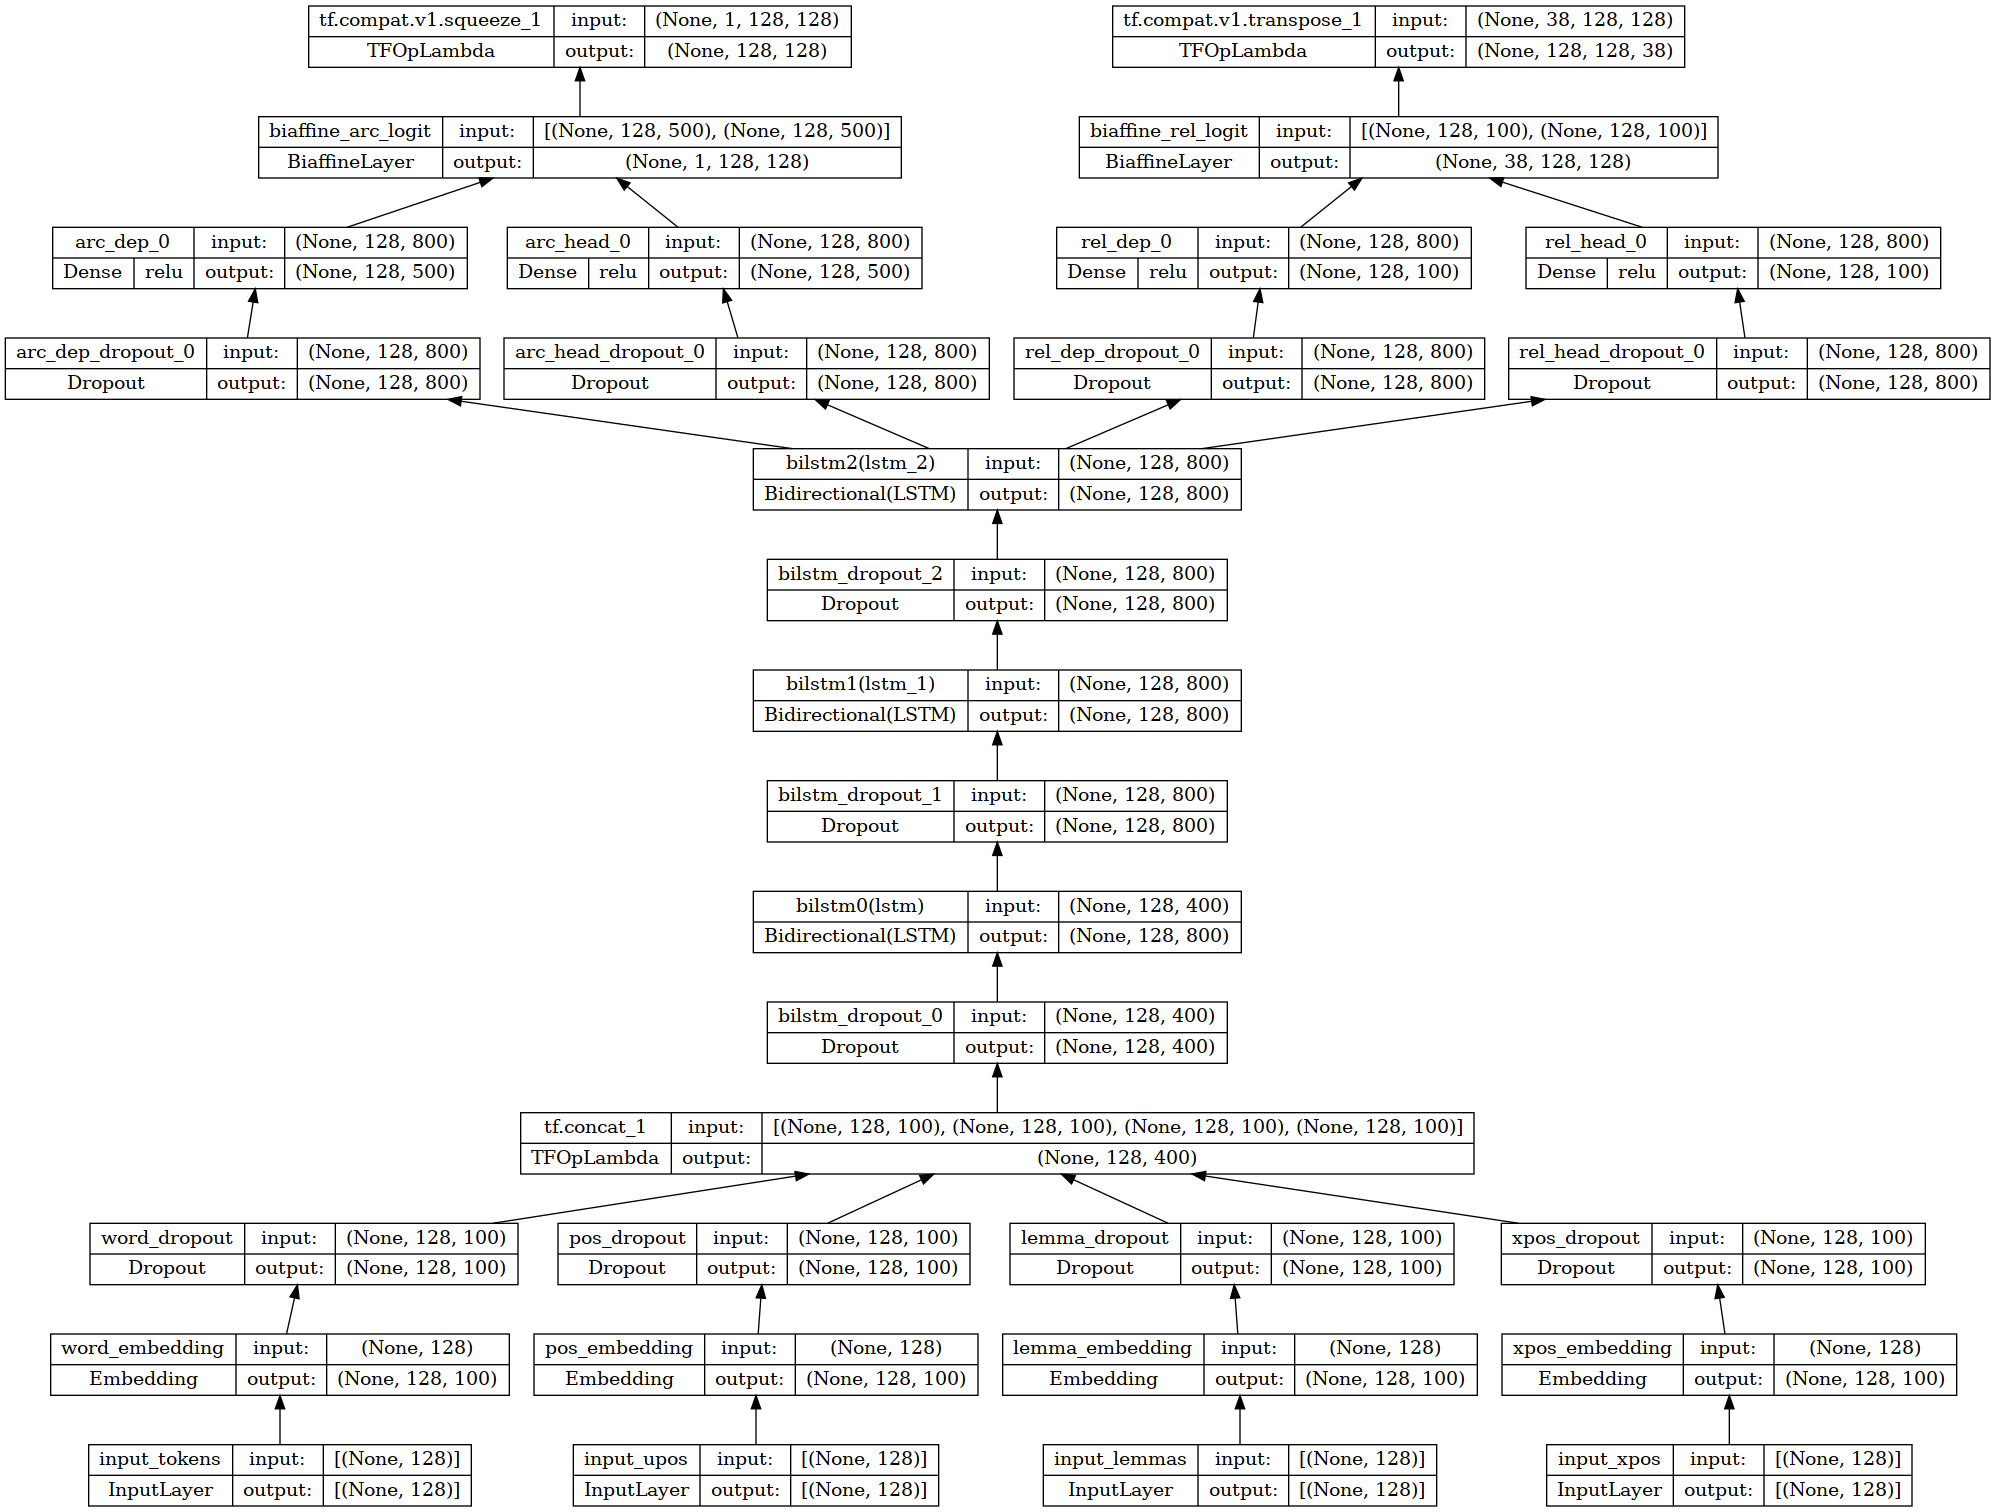

In [42]:
plot_model(model_functional, show_shapes=True, show_layer_names=True, rankdir="BT", show_layer_activations=True)

The following cell creates a directory named `logs/`, appended with the current date and time, where the TensorBoard logs will be stored. It then defines a dictionary, `params`, from the `config` object, excluding any items where the key ends with '_size'. This dictionary holds the model's hyperparameters. A file writer is established in the log directory to write TensorBoard logs. The `hp.hparams` function is used to log the hyperparameters, which can subsequently be visualized and compared in TensorBoard. Lastly, a TensorBoard callback is created with the log directory and the histogram frequency set to 1, indicating that histograms will be computed every epoch. This callback can be passed to the `fit` method of a TensorFlow model to initiate logging data for TensorBoard.

In [43]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
params = {k: v for k, v in config.__dict__.items() if not k.endswith('_size')}

with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams(params)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The custom `BiaffineAttentionModelCheckpoint` class inherits from the `Callback` class provided by TensorFlow. It overrides the `__init__` method to accept parameters for the filepath where the model should be saved, the metrics to monitor (`LAS` and `UAS`), the mode (`max` or `min`), and whether to only save the model when it has the best performance so far (`save_best_only`).

The `on_epoch_end` method is called at the end of each epoch during training. If `save_best_only` is `True`, it checks whether the current performance (based on `LAS` and `UAS`) is better than the best performance seen so far. If it is, it updates the best performance and saves the model. Otherwise, it saves the model at the end of every epoch regardless of performance.

In [44]:
# class BiaffineAttentionModelCheckpoint(Callback):
#     def __init__(self, filepath, monitor1='LAS', monitor2='UAS', mode='max', save_best_only=True, save_weights_only=False):
#         super().__init__()
#         self.filepath = filepath
#         self.monitor1 = monitor1
#         self.monitor2 = monitor2
#         self.mode = mode
#         self.save_best_only = save_best_only
#         self.save_weights_only = save_weights_only
#         self.best_eval_score = log_dir + '/best_eval_score'
#         self.best_eval_summary_writer = tf.summary.create_file_writer(self.best_eval_score)
#         if mode == 'max':
#             self.monitor_op = max
#             self.best = float('-inf')
#         elif mode == 'min':
#             self.monitor_op = min
#             self.best = float('inf')

#     def on_epoch_end(self, epoch, logs=None):
#         current1 = logs.get(self.monitor1)
#         current2 = logs.get(self.monitor2)
#         if self.save_best_only:
#             if self.monitor_op(current1, current2) > self.best:
#                 self.best = self.monitor_op(current1, current2)
#                 with self.best_eval_summary_writer.as_default():
#                     tf.summary.scalar('best_eval_LAS', current1, step=epoch)
#                     tf.summary.scalar('best_eval_UAS', current2, step=epoch)
#                 if self.save_weights_only:
#                     self.model.save_weights(self.filepath, overwrite=True)
#                 else:
#                     self.model.save(self.filepath, overwrite=True, save_format='tf')
#         else:
#             if self.save_weights_only:
#                 self.model.save_weights(self.filepath, overwrite=True)
#             else:
#                 self.model.save(self.filepath, overwrite=True, save_format='tf')

In [45]:
class BiaffineAttentionModelCheckpoint(Callback):
    def __init__(self, filepath, eval_data, monitor1='LAS', monitor2='UAS', mode='max', save_best_only=True, save_weights_only=False):
        super().__init__()
        self.filepath = filepath
        self.eval_data = eval_data
        self.monitor1 = monitor1
        self.monitor2 = monitor2
        self.mode = mode
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.best_eval_score = log_dir + '/best_eval_score'
        self.best_eval_summary_writer = tf.summary.create_file_writer(self.best_eval_score)
        if mode == 'max':
            self.monitor_op = max
            self.best = float('-inf')
        elif mode == 'min':
            self.monitor_op = min
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = self.model.evaluate(self.eval_data, return_dict=True)
        current1 = logs.get(self.monitor1)
        current2 = logs.get(self.monitor2)
        if self.save_best_only:
            if self.monitor_op(current1, current2) > self.best:
                self.best = self.monitor_op(current1, current2)
                with self.best_eval_summary_writer.as_default():
                    tf.summary.scalar('best_eval_LAS', current1, step=epoch)
                    tf.summary.scalar('best_eval_UAS', current2, step=epoch)
                if self.save_weights_only:
                    self.model.save_weights(self.filepath, overwrite=True)
                else:
                    self.model.save(self.filepath, overwrite=True, save_format='tf')
        else:
            if self.save_weights_only:
                self.model.save_weights(self.filepath, overwrite=True)
            else:
                self.model.save(self.filepath, overwrite=True, save_format='tf')

Upon defining the class, an instance of this callback is created. This instance can be passed to the `fit` method of a model during training. It is configured to save the model to a file named 'model', monitor the `LAS` and `UAS` metrics, and consider higher values of these metrics as better (`mode='max'`). It is set to save the model only when it achieves the best performance so far (`save_best_only=True`). However, during the testing phase of the training process, this value is typically set to `False` to ensure the model is saved at the end of every epoch.

In [46]:
biaffine_checkpoint = BiaffineAttentionModelCheckpoint(
    "./saved_model_weights/model_weights",
    eval_data = dev_data,
    monitor1="LAS",
    monitor2="UAS",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)

The model is now ready for training.  

Although MLflow logs are not presented in this notebook, given that TensorBoard logs are more convenient for sharing, they were used during the evaluation process and will be retained here. If MLflow is required, comment the following cell and uncomment out the subsequent two cells.

In [47]:
model.fit(
        train_data,
        epochs=config.num_epochs,
        validation_data=dev_data,
        callbacks=[tensorboard_callback, biaffine_checkpoint],
    )

Epoch 1/80


2024-04-17 17:53:48.848806: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-17 17:53:49.990047: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5875653680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-17 17:53:49.990091: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-17 17:53:50.004333: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713365630.097714   32387 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 [==============================] - 36s 357ms/step - loss: 7.0833 - UAS: 0.0707 - LAS: 0.0124 - val_UAS: 0.3185 - val_LAS: 0.1467
Epoch 2/80
70/70 [==============================] - 9s 136ms/step - loss: 2.1826 - UAS: 0.4658 - LAS: 0.2979 - val_UAS: 0.7834 - val_LAS: 0.6765
Epoch 3/80
70/70 [==============================] - 9s 130ms/step - loss: 1.0840 - UAS: 0.7720 - LAS: 0.6644 - val_UAS: 0.8308 - val_LAS: 0.7555
Epoch 4/80
70/70 [==============================] - 10s 136ms/step - loss: 0.8102 - UAS: 0.8234 - LAS: 0.7424 - val_UAS: 0.8615 - val_LAS: 0.7965
Epoch 5/80
70/70 [==============================] - 9s 129ms/step - loss: 0.6735 - UAS: 0.8570 - LAS: 0.7880 - val_UAS: 0.8745 - val_LAS: 0.8145
Epoch 6/80
70/70 [==============================] - 9s 131ms/step - loss: 0.5839 - UAS: 0.8775 - LAS: 0.8150 - val_UAS: 0.8823 - val_LAS: 0.8268
Epoch 7/80
70/70 [==============================] - 10s 138ms/step - loss: 0.5173 - UAS: 0.8917 - LAS: 0.8367 - val_UAS: 0.8896 - val_LAS: 

In [48]:
# mlflow.login()

In [49]:
# mlflow.set_experiment("/dependency_parser")
# mlflow.tensorflow.autolog(disable=True)

# with mlflow.start_run() as run:
#     mlflow.log_params(params)
    
#     model.fit(
#         train_data,
#         epochs=config.num_epochs,
#         validation_data=dev_data,
#         callbacks=[tensorboard_callback, MLflowCallback(run), biaffine_checkpoint],
#     )

This is the final score on the test dataset:

In [50]:
model.load_weights("./saved_model_weights/model_weights")
result = model.evaluate(test_data)
print(f"UAS: {result['UAS']*100:.2f}\nLAS: {result['LAS']*100:.2f}")

test_log_dir = log_dir + "/test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

with test_summary_writer.as_default():
    tf.summary.scalar('test_UAS', result['UAS'], step=1)
    tf.summary.scalar('test_LAS', result['LAS'], step=1)

UAS: 92.63
LAS: 88.62


## <a id='toc2_7_'></a>[Experiments and Results](#toc0_)

The model was tested on the Bulgarian UD treebank, and the results were evaluated using the Unlabeled Attachment Score (UAS) and Labeled Attachment Score (LAS). The UAS measures the percentage of words that are correctly attached to their head, while the LAS measures the percentage of words that are correctly attached to their head with the correct dependency relation. The model achieved a UAS of 92.25 and a LAS of 87.93 on the test dataset, indicating that it is capable of accurately predicting the dependency parse tree of a sentence.

The best scores seems to be achieved when the dropout rate is set to 0.5, which is more than the value reported by Dozat and Manning (2017). It could be explained by the fact that the Bulgarian UD treebank is smaller than the English UD treebank, and the model requires more regularization to prevent overfitting. Also, the Bulgarian morphological system is much more inflected than the English one. The learning rate decay also seems to be beneficial for the model's performance, as it allows the model to converge to a better solution. 

In the log folder created during the training process, the TensorBoard logs are stored. These logs can be visualized using the TensorBoard tool. The logs include information about the loss, UAS, and LAS metrics, as well as the hyperparameters of the model. The logs can be used to compare different models and hyperparameters, identify potential issues, and monitor the training process.

The experiments conducted thus far have enhanced the model's performance, yet there remains potential for further improvement. The model's hyperparameters, such as the optimizer's initial learning rate, adam_beta_2, and the number of LSTM and MLP layers, should be further fine-tuned to yield better results.

Additionally, the model's architecture could be modified to incorporate extra features. For instance, character-level embeddings and lemmatization could be included to further boost performance.

In [ ]:
%tensorboard --logdir logs

## <a id='toc2_8_'></a>[Predictions](#toc0_)

Firstly, the model state from the training epoch with the best validation accuracy will be loaded. The custom `BiaffineAttentionModelCheckpoint` callback saves the model at the end of each epoch if the monitored metrics improve. However, when using custom objects such as a custom loss function or a custom layer, the code for these objects isn't saved along with the model. Only the names of these objects are saved. When loading the model, Keras needs to know how to recreate these custom objects. This is why they must be provided via the `custom_objects` argument of `load_model`.

In [ ]:
best_model = load_model(
    "model",
    custom_objects={
        "BiaffineLayer": BiaffineLayer,
        "BiaffineAttentionModel": BiaffineAttentionModel,
        "loss_function": BiaffineAttentionModel.loss_function
    },
)

2024-04-17 10:20:12.519388: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'while' has 11 outputs but the _output_shapes attribute specifies shapes for 27 outputs. Output shapes may be inaccurate.
2024-04-17 10:20:12.583543: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'while' has 11 outputs but the _output_shapes attribute specifies shapes for 27 outputs. Output shapes may be inaccurate.
2024-04-17 10:20:12.948719: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'while' has 11 outputs but the _output_shapes attribute specifies shapes for 27 outputs. Output shapes may be inaccurate.
2024-04-17 10:20:13.480222: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'while' has 11 outputs but the _output_shapes attribute specifies shapes for 27 outputs. Output shapes may be inaccurate.
2024-04-17 10:20:14.800028: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'while' has 11 outputs but the _output_shapes attrib

Tokenizing the input sentences and converting them to a numerical representation, consistent with the training data, is necessary for the model to process them.

#### <a id='toc2_8_1_1_'></a>[Tokenization](#toc0_)

While the tokenization of Bulgarian UD is performed by the rule-based <a href="https://github.com/clarinsi/reldi-tokeniser">reldi_tokeniser</a>, it does not support part-of-speech (POS) tagging. This is a crucial requirement for the `BiaffineAttentionModel`, which needs both POS tags and tokens as input. Therefore, <a href="https://github.com/clarinsi/classla/tree/master?tab=readme-ov-file">CLASSLA</a> is used instead. CLASSLA is a fork of <a href="https://stanfordnlp.github.io/stanza/">Stanza</a>, designed for processing South Slavic languages, including Bulgarian, and importantly, it supports POS tagging. Before using CLASSLA, the necessary resources need to be downloaded:

In [ ]:
classla.download('bg', dir='./classla_resources')

2024-04-17 10:20:18 INFO: Downloading these customized packages for language: bg (Bulgarian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |

INFO:classla:Downloading these customized packages for language: bg (Bulgarian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |

2024-04-17 10:20:20 INFO: File exists: ./classla_resources/bg/pos/standard.pt.
INFO:classla:File exists: ./classla_resources/bg/pos/standard.pt.
2024-04-17 10:20:21 INFO: File exists: ./classla_resources/bg/lemma/standard.pt.
INFO:classla:File exists: ./classla_resources/bg/lemma/standard.pt.
2024-04-17 10:20:22 INFO: File exists: ./classla_resources/bg/depparse/standard.pt.
INFO:classla:File exists: ./classla_resou

The `classla` package offers several processors, including one for dependency parsing. However, only two of them - the tokenizer and the part-of-speech tagger - will be utilized in this context. These models are saved in an object of the `classla.pipeline.core.Pipeline` class, which is used to process the input sentences.

In [ ]:
nlp = classla.Pipeline('bg', processors='tokenize,pos', dir='./classla_resources')

2024-04-17 10:20:23 INFO: Loading these models for language: bg (Bulgarian):
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |

INFO:classla:Loading these models for language: bg (Bulgarian):
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |

2024-04-17 10:20:23 INFO: Use device: gpu
INFO:classla:Use device: gpu
2024-04-17 10:20:23 INFO: Loading: tokenize
INFO:classla:Loading: tokenize
2024-04-17 10:20:23 INFO: Loading: pos
INFO:classla:Loading: pos
2024-04-17 10:20:28 INFO: Done loading processors!
INFO:classla:Done loading processors!


#### <a id='toc2_8_1_2_'></a>[Text to CoNLL-U](#toc0_)

The `predict_text` function accepts a text input and predicts its dependency parsing structure using the trained model. The input text string undergoes processing via the `nlp` pipeline, resulting in tokenization and assignment of part-of-speech tags to each token. These words and tags are then mapped to their corresponding IDs, as defined by `token2id` and `upos2id` respectively. Each sequence of word and part-of-speech tag IDs is padded to the defined maximum length, with zeros added at the end if necessary. These padded sequences are fed into the model, which generates tensors containing predictions for the head of each word and the type of dependency relation. Postprocessing is applied to each sentence to find the predicted head and relation type for each word (as detailed in the function comments). The function converts the predicted relation IDs back to strings, constructs a CoNLL-U formatted string for each sentence, and returns a list of these CoNLL-U formatted strings, one for each sentence in the input text.

In [ ]:
def predict_text(text):
    doc = nlp(text)
    
    words_as_str = []
    upos_as_str = []
    words = []
    upos_mapped = []
    lengths = []

    for sentence in doc.sentences:
        sentence_words = [word.text for word in sentence.words]
        sentence_upos = [word.upos for word in sentence.words]
        words_as_str.append(sentence_words)
        upos_as_str.append(sentence_upos)

        sentence_words_ids = [1] + [token2id[tf.constant(word)] for word in sentence_words]
        words.append(sentence_words_ids)

        sentence_upos_ids = [1] + [upos2id[str2upos[tf.constant(upos)]] for upos in sentence_upos]
        upos_mapped.append(sentence_upos_ids)

        lengths.append(len(sentence.words) + 1)

    padded_words = tf.keras.preprocessing.sequence.pad_sequences(words, padding="post", truncating="post", maxlen=config.padding_size)
    padded_upos = tf.keras.preprocessing.sequence.pad_sequences(upos_mapped, padding="post", truncating="post", maxlen=config.padding_size)

    predictions = model.predict((padded_words, padded_upos))

    sentences = []
    for i, _ in enumerate(doc.sentences):
        # Get the arc and relation predictions for the current sentence
        arc_predictions, rel_predictions = predictions[0][i], predictions[1][i]

        # For the arc predictions, find the maximum value in each row
        # This gives the predicted head for each word
        arc_head = tf.argmax(arc_predictions, axis=-1, output_type=tf.int32)

        # For the relation predictions, first find the maximum value in the last dimension
        # This gives the predicted relation for each word pair
        rel_argmax = tf.argmax(rel_predictions, axis=-1, output_type=tf.int32)

        # Predicted heads are used to select the predicted relation for each word
        indices = tf.stack([tf.range(tf.shape(arc_head)[0], dtype=tf.int32), arc_head], axis=-1)
        rel_type = tf.gather_nd(rel_argmax, indices)

        # Apply mask for the current sentence to remove padding tokens
        mask = tf.sequence_mask(lengths[i], tf.shape(padded_words)[1])
        arc_head_masked = tf.boolean_mask(arc_head, mask)
        rel_type_masked = tf.boolean_mask(rel_type, mask)

        s_tokens = words_as_str[i]
        s_upos = upos_as_str[i]
        
        # Remove the <ROOT> token
        arc_heads = arc_head_masked[1:]
        # Convert the predicted relation ids to strings and remove the <ROOT> token
        rel_types = [id2deprel[x].numpy().decode('utf-8') for x in rel_type_masked][1:] 
        
        conllu_lines = [f"{j+1}\t{token}\t_\t{upos}\t_\t_\t{arc_head}\t{rel_type}\t_\t_"
                        for j, (token, upos, arc_head, rel_type) in enumerate(zip(s_tokens, s_upos, arc_heads, rel_types))]
        sentences.append("\n".join(conllu_lines))

    return sentences

#### <a id='toc2_8_1_3_'></a>[Visualization](#toc0_)

For visualizing the dependency parse tree, a modified version of a <a href="https://github.com/explosion/spaCy/discussions/1215">code proposed in the spaCy GitHub repository</a> is utilized. This code converts CoNLL-U to a displaCy treebank.

In [ ]:
                           
def conll_u_string2displacy_json(conll_u_sent_string): 

    conll_u_lines = [line for line in conll_u_sent_string.split("\n") \
                     if line[0].isnumeric()]

    displacy_json = {"arcs": [], "words": []}
    for tabbed_line in conll_u_lines:

        word_line = {}
        word_line["id"], word_line["form"], word_line["lemma"], \
        word_line["upostag"], word_line["xpostag"], word_line["feats"], \
        word_line["head"], word_line["deprel"], word_line["deps"], \
        word_line["misc"] = tabbed_line.split("\t")

        # CONLLU numbering starts at 1, displaCy's at 0...
        word_line["id"] = str(int(word_line["id"]) - 1)
        if word_line["head"] != "_":
            word_line["head"] = str(int(word_line["head"]) - 1)       
        
        if word_line["deprel"] != "root" and word_line["head"] != "_":
            # Displacy's 'start' value is the lowest value amongst the ID and HEAD values,
            # and the 'end' is always the highest. 'Start' and 'End' have nothing to do
            # with dependency which is indicated by the arrow direction, not the line direction.
            word_line["start"] = min([int(word_line["id"]), int(word_line["head"])])
            word_line["end"] = max([int(word_line["id"]), int(word_line["head"])])

            # Sets the orientation of the arrow that notes the direction of the dependency between the two units.
            if int(word_line["id"]) > int(word_line["head"]):
                word_line["dir"] = "right"
            elif int(word_line["id"]) < int(word_line["head"]):
                word_line["dir"] = "left"

            displacy_json["arcs"].append({"dir": word_line["dir"],
                                          "end": word_line["end"],
                                          "label": word_line["deprel"],
                                          "start": word_line["start"]})
            
        displacy_json["words"].append({"tag": word_line["upostag"],
                                       "text": word_line["form"]})

    return displacy_json

The `predict_sentences` function allows the user to input one or more sentences in Bulgarian. It then uses the `predict_text` function to generate dependency parsing predictions for these sentences in the CoNLL-U format. To prevent memory overload when more than one sentence is entered, the function prompts the user to select a single sentence for visualization. The chosen sentence undergoes conversion to a format suitable for visualization with the `displacy` module from the `spacy` library. Consequently, the dependency structure of the sentence is displayed.

In [ ]:
def predict_sentences():
    sentences = input("Please enter a sentence or sentences in Bulgarian: ")
    sentences_in_conllu = predict_text(sentences)
    idx = 1
    if len(sentences_in_conllu) > 1:
        print(f"You've entered {len(sentences_in_conllu)} sentences. Which one would you like to visualize?")
        print(f"Please enter a number between 1 and {len(sentences_in_conllu)}:")
        while True:
            try:
                idx = int(input())
                if 0 < idx <= len(sentences_in_conllu):
                    break
                else:
                    print(f"Please enter a number between 1 and {len(sentences_in_conllu)}:")
            except ValueError:
                print(f"Please enter a number between 1 and {len(sentences_in_conllu)}:")
    sentence_to_display = conll_u_string2displacy_json(sentences_in_conllu[idx-1])
    displacy.render(sentence_to_display, manual=True, jupyter=True, style='dep', options={'distance': 120, "arrow_spacing": 12})
    

#### <a id='toc2_8_1_4_'></a>[Demo](#toc0_)

By executing the next cell, the model can be tested on a few sentences.

In [ ]:
# Example sentences:
# Две малки момчета играеха вчера в парка зад училището.
# Това е тестово изречение. То е много кратко, а е важно да се тества моделът и с дълги изречения.
predict_sentences()

ValueError: in user code:

    File "/home/nasso/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/nasso/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nasso/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/nasso/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/nasso/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filew00vc6fp.py", line 10, in tf__call
        input_tokens, input_upos, input_lemmas, input_xpos = ag__.ld(inputs)

    ValueError: Exception encountered when calling layer 'biaffine_attention_model' (type BiaffineAttentionModel).
    
    in user code:
    
        File "/tmp/ipykernel_907/84138583.py", line 142, in call  *
            input_tokens, input_upos, input_lemmas, input_xpos = inputs
    
        ValueError: not enough values to unpack (expected 4, got 2)
    
    
    Call arguments received by layer 'biaffine_attention_model' (type BiaffineAttentionModel):
      • inputs=('tf.Tensor(shape=(None, 128), dtype=int32)', 'tf.Tensor(shape=(None, 128), dtype=int32)')


## <a id='toc2_9_'></a>[Future Work](#toc0_)

The model performs well on the Bulgarian UD treebank and its results are near the state-of-art parsers, but it can be further improved. The following are some potential areas for improvement:
- **Hyperparameter tuning**: The model's hyperparameters can be further optimized to improve its performance. This includes (but not restricted to) the learning rate, the number of layers in the BiLSTM, the number of units in the MLPs, and the dropout rate.
- **Additional inputs**: The model can be extended to accept additional inputs, such as lemmatized forms of the words, morphological features, and named entity recognition tags. These inputs can be used to improve the model's performance.
- **Better embeddings**: The model can be improved by using better word embeddings, such as pre-trained word embeddings or contextual word embeddings. 

## <a id='toc2_10_'></a>[Conclusion](#toc0_)
The project has successfully implemented a neural network-based dependency parser using TensorFlow and Keras. The parser was trained and evaluated on the Bulgarian Universal Dependencies dataset. The parser achieved competitive results, demonstrating the effectiveness of the proposed architecture. The original model of Dozat and Manning is evaluated on much larger datasets and on laguages with simpler morphological structure, but the results are comparable (for example, better scores than tahe original model shows for Chinese, and near the results for Czech, which has one of the biggest treebanks). The parser can be used to predict the dependency parsing structure of Bulgarian sentences, and the predictions can be visualized using the `displacy` module from the `spacy` library. The parser can be further improved by optimizing its hyperparameters, adding additional inputs, and using better word embeddings.

## <a id='toc2_11_'></a>[References](#toc0_)
1. <a id="ref-1"></a> Dozat, T., & Manning, C. D. (2017). [Deep Biaffine Attention for Neural Dependency Parsing](https://openreview.net/forum?id=Hk95PK9le). In _International Conference on Learning Representations_.    
2. <a id="ref-2"></a> Kiperwasser, E., & Goldberg, Y. (2016). [Simple and accurate dependency parsing using bidirectional LSTM feature representations](https://aclanthology.org/Q16-1023/). In _Transactions of the Association for Computational Linguistics_, 4, 313-327. MIT Press.
3. <a id="ref-4"></a> Kingma, D. P., & Ba, J. (2014). [Adam: A method for stochastic optimization](https://arxiv.org/abs/1412.6980). _arXiv preprint arXiv:1412.6980_.
4. <a id="ref-3"></a> GitHub Repositories:
   - [https://github.com/rmodi6/dependency-parsing/tree/master](https://github.com/rmodi6/dependency-parsing/tree/master)
   - [https://github.com/chantera/biaffineparser](https://github.com/chantera/biaffineparser)
   - [https://github.com/codogogo/towerparse/tree/main](https://github.com/codogogo/towerparse/tree/main)
   - [https://github.com/dwdb/dependency-parser](https://github.com/dwdb/dependency-parser)
   - [https://github.com/Impavidity/Biaffine-Parsing-Pytorch/tree/master](https://github.com/Impavidity/Biaffine-Parsing-Pytorch/tree/master)
   - [https://github.com/Unipisa/diaparser/tree/master](https://github.com/Unipisa/diaparser/tree/master)